In [ ]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import logging
import time
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'

Mounted at /content/drive


In [ ]:
# Specify the file path of your CSV file
#file_path = 'normalized_df.csv'

# the current script directory
# the current working directory
#current_dir = os.getcwd()

# the path to the CSV file in the parent directory
#parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
#file_path = os.path.join(parent_dir, 'normalized_df.csv')

# Read the CSV file
data = pd.read_csv(file_path)

print("Imported data:")
print(data)

Imported data:
                        time    blr_mod_lvl  absorption  insulation  t_r_set  \
0        2022-10-01 00:00:00   0.000000e+00    0.503910    7.457292     15.0   
1        2022-10-01 00:01:00   0.000000e+00    0.503910    7.455208     15.0   
2        2022-10-01 00:02:00   0.000000e+00    0.518558    7.487500     15.0   
3        2022-10-01 00:03:00   0.000000e+00    0.616207    7.426042     15.0   
4        2022-10-01 00:04:00   0.000000e+00    0.699210    7.425000     15.0   
...                      ...            ...         ...         ...      ...   
7331983  2023-04-30 23:55:00  2.871866e-119         NaN    1.604167     17.0   
7331984  2023-04-30 23:56:00  1.914578e-119         NaN    1.614583     17.0   
7331985  2023-04-30 23:57:00  1.276385e-119         NaN    1.572917     17.0   
7331986  2023-04-30 23:58:00  8.509234e-120         NaN    1.511458     17.0   
7331987  2023-04-30 23:59:00  5.672823e-120         NaN    1.432203     17.0   

             t_out house

In [ ]:
# Different houses in data
houses = data['house_id'].unique()
print("Different houses in data:")
print(houses)
print("Number of different houses:")
print(len(houses))

Different houses in data:
['home2' 'home9' 'home13' 'home14' 'home34' 'home46' 'home55' 'home67'
 'home86' 'home93' 'home101' 'home106' 'home110' 'home43' 'home63'
 'home53' 'home79' 'home90' 'home95' 'home5' 'home17' 'home47' 'home51'
 'home65' 'home77' 'home89' 'home111' 'home114']
Number of different houses:
28


In [ ]:
house_datasets = {}
for house in houses:
    house_datasets[house] = data[data['house_id'] == house]

#print(house_datasets)

**Δημιουργία του encoder decoder transformer**

In [ ]:
# positional encoding layer
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


# positional embedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
# Attention layers
# These are all identical except for how the attention is configured

# base attention layer
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


# cross attention layer
# (at the center of the Transformer is the cross-attention layer, it connects the encoder and decoder)
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# global self attention layer
# (it is responsible for processing the context sequence, and propagating information along its length)
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# causal self attention layer
# (it does a similar job as the global self attention layer, for the output sequence)
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
# feed forward network
# (the transformer also includes this point-wise feed-forward network in both the encoder and decoder)
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
# encoder layer
# (the encoder contains a stack of N encoder layers. Where each EncoderLayer contains
#   a GlobalSelfAttention and FeedForward layer)
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
# The Encoder
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# decoder layer
# (the decoder's stack is slightly more complex, with each DecoderLayer containing
#   a CausalSelfAttention, a CrossAttention, and a FeedForward layer)
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
# The Decoder
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None


  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# The Transformer
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size, dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size, dropout_rate=dropout_rate)

    #self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    self.final_layer = tf.keras.layers.Dense(1)


  def call(self, inputs):  # Expecting only one input
    x = inputs
    context = self.encoder(x)
    x = self.decoder(x, context)
    logits = self.final_layer(x)
    try:
      del logits._keras_mask
    except AttributeError:
      pass
    return logits

**Preparing the data**

In [ ]:
# the categories for prediction
final_category = 'blr_mod_lvl'
prediction_categories = ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']


In [ ]:
# function to prepare data before use with transformer
def prepare_data(house_data, input_category, output_category, minutes_per_day=1440):
    # get input and output data
    house_data = house_data.sort_values(by='time')
    input = house_data[input_category].values
    output = house_data[output_category].values

    # number of days
    days = len(output) // minutes_per_day
    # the data into a list of sub-lists, each containing one day's data
    input_data = [
        input[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(days)
    ]
    output_data = [
        output[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(days)
    ]
    # [:, :-1] and [:, 1:] for 2-d arrays
    # [:-1],  and [1:] for 1-d arrays (or lists)
    # all except last day are inputs (for prediction)
    input_data = input_data[:-1]
    # all except first day are the corresponding outputs (from prediction)
    output_data = output_data[1:]

    return input_data, output_data


In [ ]:
# Filter data for the 'absorption' category
#category = 'absorption'
filtered_data = data[['house_id', 'time', 'blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']].copy()

# We have 1440 minutes per day
minutes_per_day = 1440

# Function to create input-target pairs for a single house
#def create_pairs(house_data, category, minutes_per_day=1440):
#    house_data = house_data.sort_values(by='time')
#    data = house_data[category].values
#    days = len(data) // minutes_per_day
#    data = data[:days * minutes_per_day].reshape((days, minutes_per_day))
#    input_data = data[:-1]
#    target_data = data[1:]
#    return input_data, target_data

# Initialize lists to store input and target pairs
input_data_list, target_data_list = [], []

for house_id in houses:
    house_data = filtered_data[filtered_data['house_id'] == 'home14']
    #input_data, target_data = create_pairs(house_data, category)
    input_data, target_data = prepare_data(house_data, 'absorption', 'blr_mod_lvl')
    input_data_list.append(input_data)
    target_data_list.append(target_data)

# Combine all houses' data
input_data = np.concatenate(input_data_list, axis=0)
target_data = np.concatenate(target_data_list, axis=0)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# Data normalization for input and target data
scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()

# Normalize input
input_data = np.array(input_data)
input_data_normalized = scaler_input.fit_transform(input_data)

# Normalize target
target_data = np.array(target_data)
target_data_normalized = scaler_target.fit_transform(target_data)

# for predictions: normalize-predict-denormalize
# Normalize new data
# Predict
#  predictions_normalized = model.predict(new_input_data_normalized)
# Denormalize predictions
#  predictions = scaler_target.inverse_transform(predictions_normalized)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Properly split datasets for train, validation, test
# from original data: 80%-20% split, where 20% is for test. from remaining 80% : 80%-20% split, for train and validation

batch_size = 8 # Reduce the batch size, in case it helps !

# Split the data into train+val and test sets
input_train_val, input_test, target_train_val, target_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

# Further split train+val into train and val sets
input_train, input_val, target_train, target_val = train_test_split(input_train_val, target_train_val, test_size=0.2, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
train_dataset = train_dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((input_val, target_val))
val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test))
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
# Define the Transformer model
#model = Transformer(num_layers=4, d_model=128, num_heads=8, dff=512, input_vocab_size=minutes_per_day,
#                    target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440
model = Transformer(num_layers=4, d_model=64, num_heads=4, dff=256, input_vocab_size=minutes_per_day,
                    target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
# Evaluate the model to inspect shapes
#predictions = model.predict(train_dataset.take(1)) # Get predictions for one batch
#print("Shape of predictions:", predictions.shape)
#print("Shape of target batch:", next(iter(train_dataset))[1].shape)

In [ ]:
# Train the model
#model.fit(dataset, epochs=10)

In [ ]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with the EarlyStopping callback
history = model.fit(
    train_dataset,       # Training dataset
    epochs=20,          # Number of epochs
    validation_data=val_dataset,  # Validation dataset
    callbacks=[early_stopping]  # List of callbacks to apply during training
)
# change epochs, patience , etc !!! (e.g. epochs=10, patience=3  or  epochs=20, patience=5)

Epoch 1/20
383/383 [==============================] - 300s 784ms/step - loss: 186.9140 - mean_absolute_error: 7.5393 - val_loss: 174.6896 - val_mean_absolute_error: 7.6219
Epoch 2/20
383/383 [==============================] - 322s 841ms/step - loss: 164.2867 - mean_absolute_error: 6.7835 - val_loss: 131.5309 - val_mean_absolute_error: 6.0376
Epoch 3/20
383/383 [==============================] - 323s 843ms/step - loss: 121.8305 - mean_absolute_error: 5.4450 - val_loss: 108.2460 - val_mean_absolute_error: 4.9295
Epoch 4/20
383/383 [==============================] - 308s 804ms/step - loss: 87.8329 - mean_absolute_error: 4.3673 - val_loss: 68.3476 - val_mean_absolute_error: 3.4570
Epoch 5/20
383/383 [==============================] - 307s 802ms/step - loss: 66.3847 - mean_absolute_error: 3.6483 - val_loss: 50.0868 - val_mean_absolute_error: 2.6989
Epoch 6/20
383/383 [==============================] - 308s 805ms/step - loss: 52.8919 - mean_absolute_error: 3.1606 - val_loss: 38.4619 - val_me

In [ ]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_dataset, return_dict=True)
#print(f"Test Loss (MSE): {test_results['loss']}, Test MAE: {test_results['mean_absolute_error']}")

# model.predict() !!! (not model.evaluate)

120/120 [==============================] - 34s 283ms/step - loss: 11.7633 - mean_absolute_error: 1.2078


In [ ]:
predictions = model.predict(test_dataset)

120/120 [==============================] - 35s 280ms/step


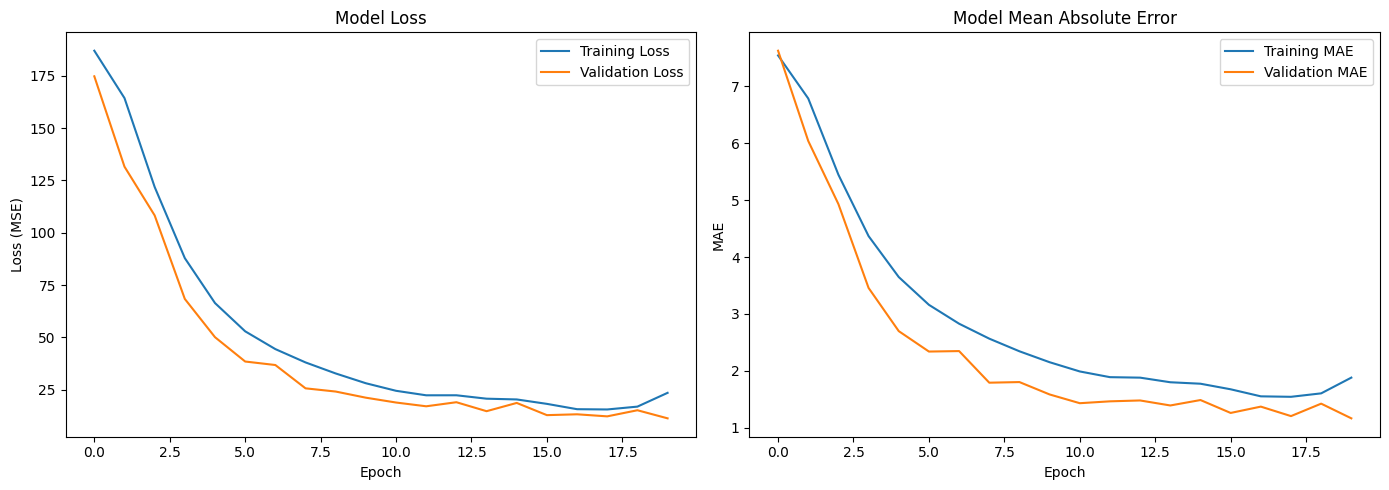

In [ ]:
# Plotting the training and validation loss and MAE
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()